<a href="https://colab.research.google.com/github/visiont3lab/deep-learning-course/blob/main/colab/CovidMaskClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolution neural network Covid-19 Mask Classifier

Link utili dove poter scaricare datasets
* [Kaggle](https://www.kaggle.com/datasets?fileType=csv)
* [Google dataset](https://www.kaggle.com/datasets?fileType=csv)
* [Covid-19 Mask Dataset Github](https://github.com/visiont3lab/covid-mask-classifier.git)
* [Medical MNSIT]([Kaggle](https://www.kaggle.com/andrewmvd/medical-mnist))
* [Pytorch Cifar 10 dataset Tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)
* [Paper with code Image classification Cifar dataset](https://paperswithcode.com/sota/image-classification-on-cifar-10)
* [AdaptiveAvgPool2d](https://pytorch.org/docs/master/generated/torch.nn.AdaptiveAvgPool2d.html#torch.nn.AdaptiveAvgPool2d)
* [AlexNet Pytorch](https://pytorch.org/vision/stable/_modules/torchvision/models/alexnet.html)

Useful bash commands

```
!rm -rf images
!mkdir -p images
!zip -r images.zip images
```




## Imoport Library

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader,Dataset
from torch import optim
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
import cv2
import torch.nn as nn
import os
from PIL import Image
from datetime import datetime
import pandas as pd
import cv2
import numpy as np
import shutil
import random
from torchsummary import summary

## Download Dataset Covid Mask Classifier


In [ ]:
!git clone https://github.com/visiont3lab/covid-mask-classifier.git

fatal: destination path 'covid-mask-classifier' already exists and is not an empty directory.


### Option 1) Data Loader from memory

In [ ]:
# Generate Train test folder
folder_path = os.path.join("covid-mask-classifier","dataset")
classes = {'mask': 0, 'no-mask': 1}
## -----------  Read Data
class_name =  list(classes.keys())
num_classes = len(class_name)
size = 256
X = []
Y = []
for i in range(0,num_classes):
    fpath = os.path.join(folder_path, class_name[i])
    for name in os.listdir(fpath):
        path_read_im = os.path.join(fpath, name)
        im = np.array( Image.open(path_read_im).convert('RGB').resize((size,size)) )
        X.append(im)
        Y.append(i)
C_X = np.array(X, dtype="float32").transpose(0,3,1,2)
C_Y = np.array(Y, dtype="float32")
C_X_train, C_X_test, C_Y_train, C_Y_test = train_test_split(C_X,C_Y,test_size=0.3,shuffle=True,random_state=2)
print(f"X Train shape: {C_X_train.shape} , X Test shape: {C_X_test.shape}")


X Train shape: (699, 3, 256, 256) , X Test shape: (300, 3, 256, 256)


tensor([0, 0, 1, 0, 0, 0, 1, 0, 0, 0])


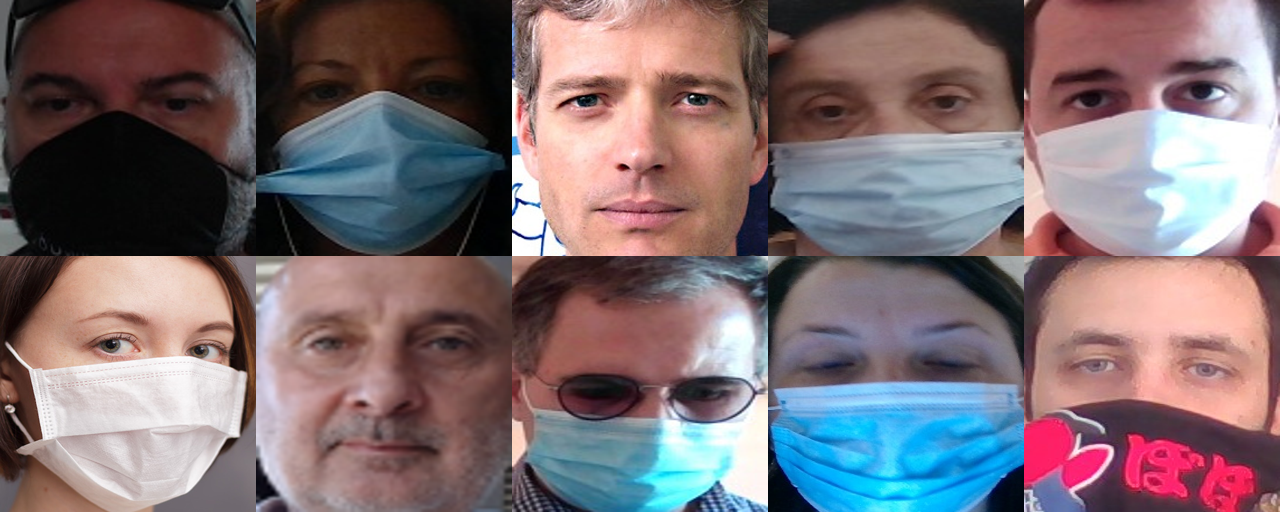

In [ ]:
data_transform = transforms.Compose([transforms.ToPILImage(),  # Tensor of Numpy array to Pillow
                                    transforms.ToTensor(),          # Pillow to tensor [0-1]
                            ])   
# Tensor Dataset Che converte i dati da numpy a Pytorch
class ImageDataset(Dataset):
    def __init__(self, x,y,transform):
        self.transform = transform
        self.x = torch.from_numpy(x).type(torch.float32)
        self.y = torch.from_numpy(y).type(torch.LongTensor).reshape(-1)
    def __getitem__(self, index):
        x = self.x[index]
        if self.transform:
          x = self.transform(x)
        y = self.y[index]
        return x, y
    def __len__(self):
        return self.x.shape[0]

C_train_ds = ImageDataset(C_X_train,C_Y_train,data_transform)
C_test_ds = ImageDataset(C_X_test,C_Y_test,data_transform)

C_train_dl = torch.utils.data.DataLoader(C_train_ds,batch_size=10,shuffle=True)
for x,y in C_train_dl: 
    print(y)
    batch_grid =torchvision.utils.make_grid(x, nrow=5, padding=0)
    im = transforms.ToPILImage()(batch_grid*255)
    display(im)
    break

### Option 2) Data Loader from Filepaths

In [ ]:
# We want to start in this case from two folder train and test
# for this example we will create train and test folder
# randomly by using this script
# Random create train and test folders
folder_path = os.path.join("covid-mask-classifier","dataset")
folder_train_path = os.path.join("covid-mask-classifier","dataset","train")
folder_test_path = os.path.join("covid-mask-classifier","dataset","test")
classes = {'mask': 0, 'no-mask': 1}
class_name =  list(classes.keys())
filepaths_train = []
filepaths_test = []
num_test_images = 100

# Create train and test directory
for c in classes.keys():
    try:
        os.makedirs(os.path.join(folder_train_path,c))
    except Exception as e:
        print(e)
    try:
        os.makedirs(os.path.join(folder_test_path,c))
    except Exception as e:
        print(e)

# Get train and test filepaths
for c in classes.keys():
    p = os.path.join(folder_path, c)
    filepaths = os.listdir(p)
    filepaths = [os.path.join(p,filepath) for filepath in filepaths]
    test = random.sample(filepaths, num_test_images)
    train = [x for x in filepaths if x not in test]
    filepaths_train.extend(train)
    filepaths_test.extend(test)
    
# Copy images inside train folder
for f in filepaths_train:
    last = "/".join(f.split("/")[-2:])
    path = os.path.join(folder_train_path,last)
    shutil.copy(f,path)

# Copy images inside test folder
for f in filepaths_test:
    last = "/".join(f.split("/")[-2:])
    path = os.path.join(folder_test_path,last)
    shutil.copy(f,path)

[Errno 17] File exists: 'covid-mask-classifier/dataset/train/mask'
[Errno 17] File exists: 'covid-mask-classifier/dataset/test/mask'
[Errno 17] File exists: 'covid-mask-classifier/dataset/train/no-mask'
[Errno 17] File exists: 'covid-mask-classifier/dataset/test/no-mask'


tensor([1, 1, 0, 1, 0, 1, 0, 0, 1, 0])


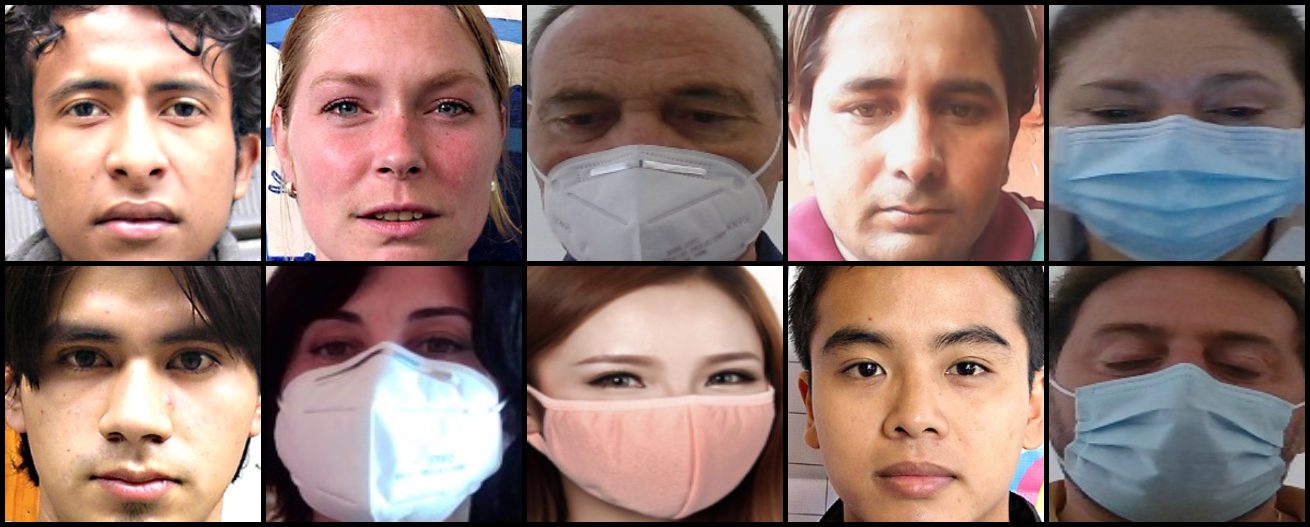

In [ ]:
# Generate Train test folder
folder_train_path = os.path.join("covid-mask-classifier","dataset","train")
folder_test_path = os.path.join("covid-mask-classifier","dataset","test")
classes = {'mask': 0, 'no-mask': 1}
## -----------  Read Data
class_name =  list(classes.keys())
num_classes = len(class_name)
size = 256 # training size

train_transform = transforms.Compose([                                    
                                    #transforms.ToPILImage(),  # Tensor of Numpy array to Pillow
                                    transforms.Resize((size,size)),
                                    #transforms.RandomApply([
                                    #    transforms.ColorJitter(brightness=0.5,contrast=0.3),
                                    #], p=0.5),
                                    #transforms.RandomApply([
                                    #    transforms.RandomAffine(degrees=3)
                                    #], p=0.5),
                                    #transforms.RandomHorizontalFlip(p=0.5), # Pillow transformation
                                    transforms.ToTensor()          # Pillow to tensor [0-1]
                            ])   
test_transform = transforms.Compose([      
                                    transforms.Resize((size,size)),                              
                                    transforms.ToTensor()          # Pillow to tensor [0-1]
                            ])  

class ImageDataset(Dataset):
    def __init__(self, folder_path,classes,transform=None):
        names = os.listdir(folder_path) 
        self.filepaths = []
        self.y = []
        for c in classes.keys():
            folder_class = os.path.join(folder_path,c)
            names = os.listdir(folder_class)
            f = [os.path.join(folder_path,c,name) for name in names]
            self.filepaths.extend(f)
            self.y.extend([classes[c] for i in range(0,len(f))])
        self.transform = transform
    def __getitem__(self, index):
        filepath = self.filepaths[index]
        y = self.y[index]
        x = Image.open(filepath).convert("RGB")
        #m = np.array(x)
        #print(m)
        if self.transform:
            x =self.transform(x)
        return x,y
    def __len__(self):
        return len(self.filepaths)

C_train_ds = ImageDataset(folder_train_path,classes,train_transform)
C_test_ds = ImageDataset(folder_test_path,classes,test_transform)

C_train_dl = torch.utils.data.DataLoader(C_train_ds,batch_size=10,shuffle=True)
for x,y in C_train_dl: 
    print(y)
    batch_grid =torchvision.utils.make_grid(x, nrow=5, padding=5)
    im = transforms.ToPILImage()(batch_grid)
    display(im)
    break

## Network

###  AlexNet Convolutional Visualization Study

In [ ]:
class AlexNet(nn.Module):

    def __init__(self,num_classes):
        super(AlexNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(64, 192, kernel_size=5, padding=2)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv3 = nn.Conv2d(192, 384, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(384, 256, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))

        self.drop1 = nn.Dropout(p=0.5)
        self.drop2 = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(256 * 6 * 6, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, num_classes)

        # Visualization purpose
        self.visualize = []

    def forward(self, x):
        self.visualize = []

        # Estrattore di feature
        self.visualize.append(x)

        x = torch.relu(self.conv1(x))
        x = self.pool1(x)
        self.visualize.append(x)

        x = torch.relu(self.conv2(x))
        x = self.pool2(x)
        self.visualize.append(x)

        x = torch.relu(self.conv3(x))
        self.visualize.append(x)

        x = torch.relu(self.conv4(x))
        self.visualize.append(x)

        x = torch.relu(self.conv5(x))
        x = self.pool3(x)
        self.visualize.append(x)

        x = self.avgpool(x)
        self.visualize.append(x)

        # Classificatore
        x = self.drop1(x)
        x = x.reshape(-1,256*6*6)
        x = torch.relu( self.fc1(x) )
        x = self.drop2(x)
        x = self.fc3(x)   

        # Log softmax
        x = torch.log_softmax(x,dim=-1)
        return x

    def plot(self):
        try:
            shutil.rmtree("images")
        except:
            pass
        try:
            os.makedirs("images")
        except:
            pass
        for x in self.visualize:
            #print(x.shape)
            xx = x[0].unsqueeze(1)
            batch_grid =torchvision.utils.make_grid(xx, nrow=20, padding=5,keep_channels=True).permute(1, 2, 0)
            #print(batch_grid.shape)
            im = batch_grid.numpy()*255
            r = datetime.now().strftime("%H-%M-%S-%f")
            im = cv2.resize(im, (1280,720))
            cv2.imwrite("images/image_"+r+".png", im)

# Test
x,y = next(iter(C_train_dl))
net = AlexNet(num_classes)

# Print model summary
summary(net,input_size=(3,256,256),batch_size=-1,device="cpu")

# Output 
out = net.forward(x)
net.plot()
print(out)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 63, 63]          23,296
         MaxPool2d-2           [-1, 64, 31, 31]               0
            Conv2d-3          [-1, 192, 31, 31]         307,392
         MaxPool2d-4          [-1, 192, 15, 15]               0
            Conv2d-5          [-1, 384, 15, 15]         663,936
            Conv2d-6          [-1, 256, 15, 15]         884,992
            Conv2d-7          [-1, 256, 15, 15]         590,080
         MaxPool2d-8            [-1, 256, 7, 7]               0
 AdaptiveAvgPool2d-9            [-1, 256, 6, 6]               0
          Dropout-10            [-1, 256, 6, 6]               0
           Linear-11                 [-1, 4096]      37,752,832
          Dropout-12                 [-1, 4096]               0
           Linear-13                    [-1, 2]           8,194
Total params: 40,230,722
Trainable para

## Training

In [ ]:
# Validation: Metric Regression
def metrics_func_regression(target, output):
  # Comptue mean squaer error (Migliora quanto piu' ci avviciniamo a zero)
  mse = torch.sum((output - target) ** 2)
  return mse

# Validation: Metric cassification
def metrics_func_classification(target, output):
  # Compute number of correct prediction
  pred = output.argmax(dim=-1,keepdim=True)
  corrects =pred.eq(target.reshape(pred.shape)).sum().item()
  return -corrects # minus for coeherence with best result is the most negative one

# Training: Loss calculation and backward step
def loss_batch(loss_func,metric_func, xb,yb,yb_h, opt=None):
  # obtain loss
  loss = loss_func(yb_h, yb)
  # obtain permormance metric 
  metric_b = metric_func(yb,yb_h)
  if opt is not None:
    loss.backward()
    opt.step()
    opt.zero_grad()
  return loss.item(), metric_b

# Trainig: Function 1 epoch
def loss_epoch(model, loss_func,metric_func, dataset_dl, opt, device):
  loss = 0.0
  metric = 0.0
  len_data = len(dataset_dl.dataset)
  # Get batch data
  for xb,yb in dataset_dl:    
    # Send to cuda the data (batch size)
    xb = xb.to(device)
    yb = yb.to(device)
    # obtain model output 
    yb_h = model.forward(xb)
    # Loss and Metric Calculation
    loss_b, metric_b = loss_batch(loss_func,metric_func, xb,yb,yb_h,opt)
    loss += loss_b
    if metric_b is not None:
      metric+=metric_b 
  loss /=len_data
  metric /=len_data
  return loss, metric

# Training: Iterate on epochs
def train_val(epochs, model, loss_func, metric_func, opt, train_dl,test_dl,device, path2weigths="./weights.pt"):
  lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.999) #  lr = lr * gamma ** last_epoch
  best_val_metric = 1000000
  for epoch in range(epochs):
    model.train()
    train_loss,train_metric = loss_epoch(model, loss_func, metric_func,train_dl, opt,device)
    lr_scheduler.step()
    model.eval()
    with torch.no_grad():
      val_loss, val_metric = loss_epoch(model, loss_func, metric_func, test_dl,opt=None,device=device)
      print("epoch: %d, train_loss: %.6f, val loss: %.6f,  train_metric: %.3f test_metric: %.3f lr: %.5f)" % (epoch,train_loss, val_loss,train_metric,val_metric,opt.param_groups[0]['lr']))
      if (val_metric <= best_val_metric):        
        # Save Models (It save last weights)
        torch.save(model.state_dict(),path2weigths)
        best_val_metric = val_metric


In [ ]:
# Setup GPU Device
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda:0")
print(device)

# Setup
C_model = AlexNet(len(classes.keys())).to(device)
C_loss_func = nn.NLLLoss(reduction="sum")
C_opt = optim.Adam(C_model.parameters(),lr=0.001)
C_train_dl = DataLoader(C_train_ds,batch_size=64,shuffle=True,num_workers=1)
C_test_dl = DataLoader(C_test_ds,batch_size=64,shuffle=True,num_workers=1)

# Train
train_val(5,C_model,C_loss_func,metrics_func_classification,C_opt, C_train_dl,C_test_dl,device,path2weigths="./weights_classification.pt")

cuda:0
epoch: 0, train_loss: 0.701982, val loss: 0.287427,  train_metric: -0.654 test_metric: -0.930 lr: 0.00100)
epoch: 1, train_loss: 0.241597, val loss: 0.217529,  train_metric: -0.928 test_metric: -0.920 lr: 0.00100)
epoch: 2, train_loss: 0.140557, val loss: 0.067314,  train_metric: -0.962 test_metric: -0.985 lr: 0.00100)
epoch: 3, train_loss: 0.114178, val loss: 0.110123,  train_metric: -0.975 test_metric: -0.962 lr: 0.00100)
epoch: 4, train_loss: 0.103058, val loss: 0.065592,  train_metric: -0.971 test_metric: -0.988 lr: 0.00100)


## Test trained model and visualization convolution filter

### Check Confusion matrix test set

In [ ]:
# Load Classification
device = torch.device("cpu")
classes = {'mask':0, 'no-mask':1}
C_model = AlexNet(len(classes)).to(device)
C_weights = torch.load("weights_classification.pt")
C_model.load_state_dict(C_weights)
C_model = C_model.to(device)

# Predict Classication
for x,y in C_test_dl:
  y_hat = C_model.forward(x).argmax(dim=-1,keepdim=True).detach().numpy().reshape(-1)

  # Visualize results
  cm = confusion_matrix(y,y_hat)
  names_pred = [ "Pred: " + n for n in classes]
  df = pd.DataFrame(cm, columns=names_pred, index=classes)
  display(df)

,Pred: mask,Pred: no-mask
mask,37,0
no-mask,1,26


,Pred: mask,Pred: no-mask
mask,29,0
no-mask,1,34


,Pred: mask,Pred: no-mask
mask,31,0
no-mask,0,33


,Pred: mask,Pred: no-mask
mask,34,1
no-mask,0,29


,Pred: mask,Pred: no-mask
mask,32,0
no-mask,0,32


,Pred: mask,Pred: no-mask
mask,34,0
no-mask,0,30


,Pred: mask,Pred: no-mask
mask,26,1
no-mask,0,37


,Pred: mask,Pred: no-mask
mask,26,1
no-mask,0,37


,Pred: mask,Pred: no-mask
mask,35,2
no-mask,0,27


,Pred: mask,Pred: no-mask
mask,7,0
no-mask,0,3


### Test and visualize one single image

mask


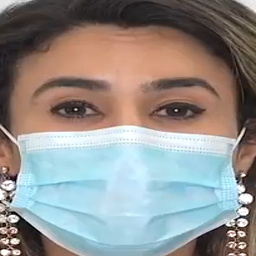

mask


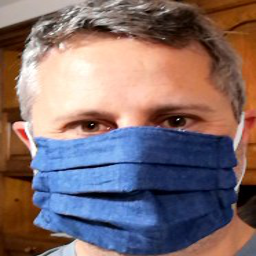

In [ ]:
# Read Image
def preprocess_image(filepath,size=256):
    #filepath = os.path.join("covid-mask-classifier","dataset","mask","5e7cded7ba85ee690669c204.jpg")
    im_pil = Image.open(filepath).convert("RGB").resize((256,256))
    im_tensor = transforms.ToTensor()( im_pil ).unsqueeze(0)
    return im_tensor, im_pil

# Load Model
device = torch.device("cpu")
classes = {'mask':0, 'no-mask':1}
result = ["mask","no-mask"]
C_model = AlexNet(len(classes)).to(device)
C_weights = torch.load("weights_classification.pt")
C_model.load_state_dict(C_weights)
C_model = C_model.to(device)
size  =256 # Training size shape

# Predict
folder_path = os.path.join("covid-mask-classifier","dataset","mask")
#folder_path = os.path.join("covid-mask-classifier","dataset","no-mask")
names = os.listdir(folder_path)
filepaths = [os.path.join(folder_path,name) for name in names]
for filepath in filepaths[3:5]:  # Show only 5 images
    im_tensor, im_pil = preprocess_image(filepath,size)
    with torch.no_grad():
        out = C_model.forward(im_tensor).numpy().argmax()
    print(result[out])
    display( im_pil )

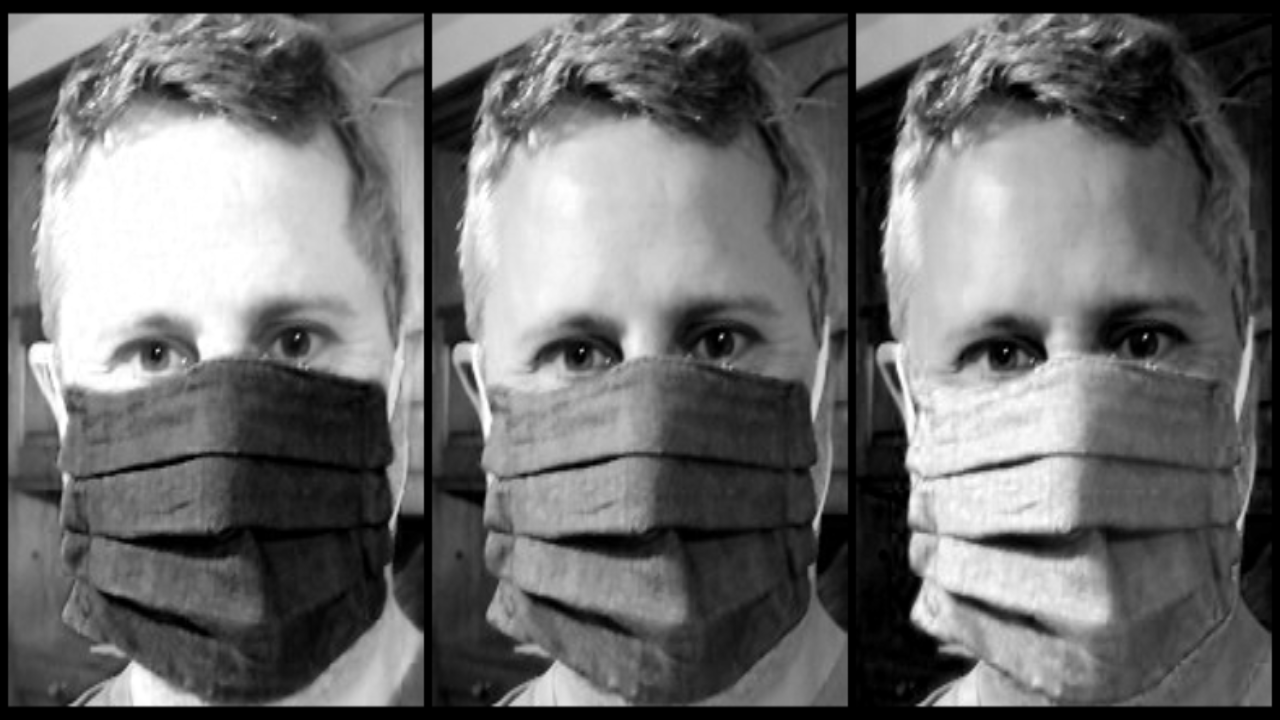

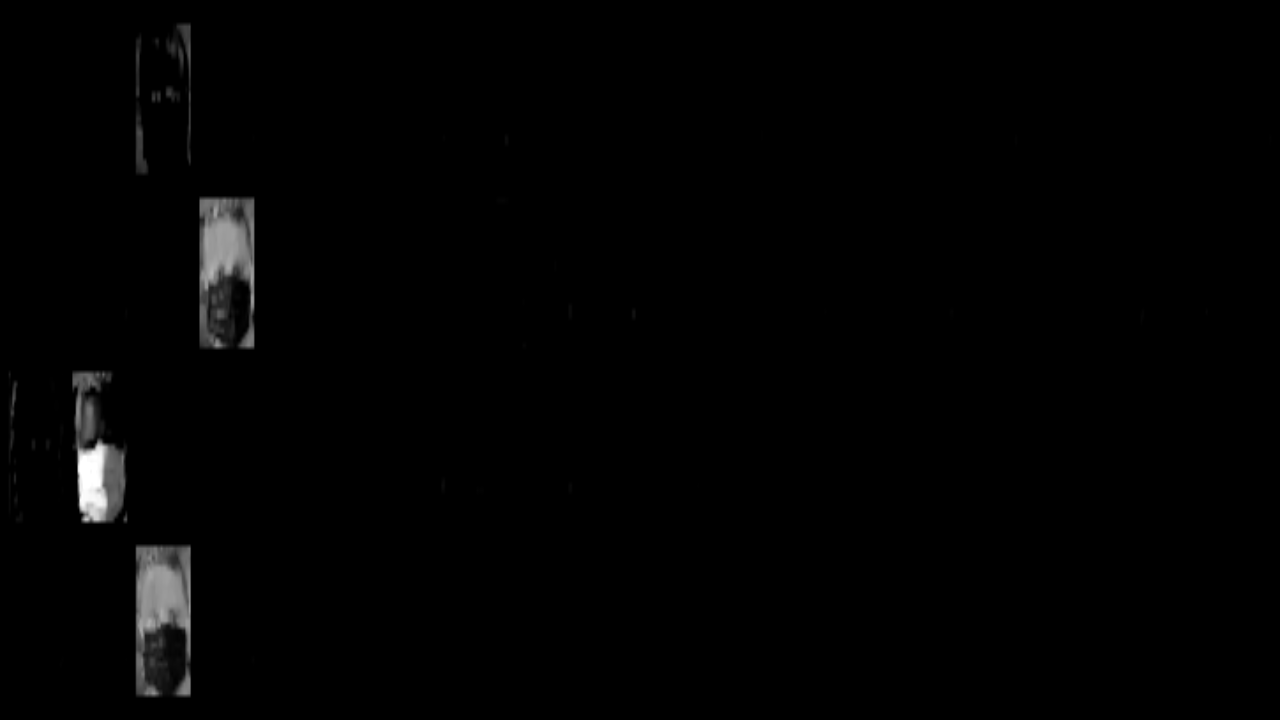

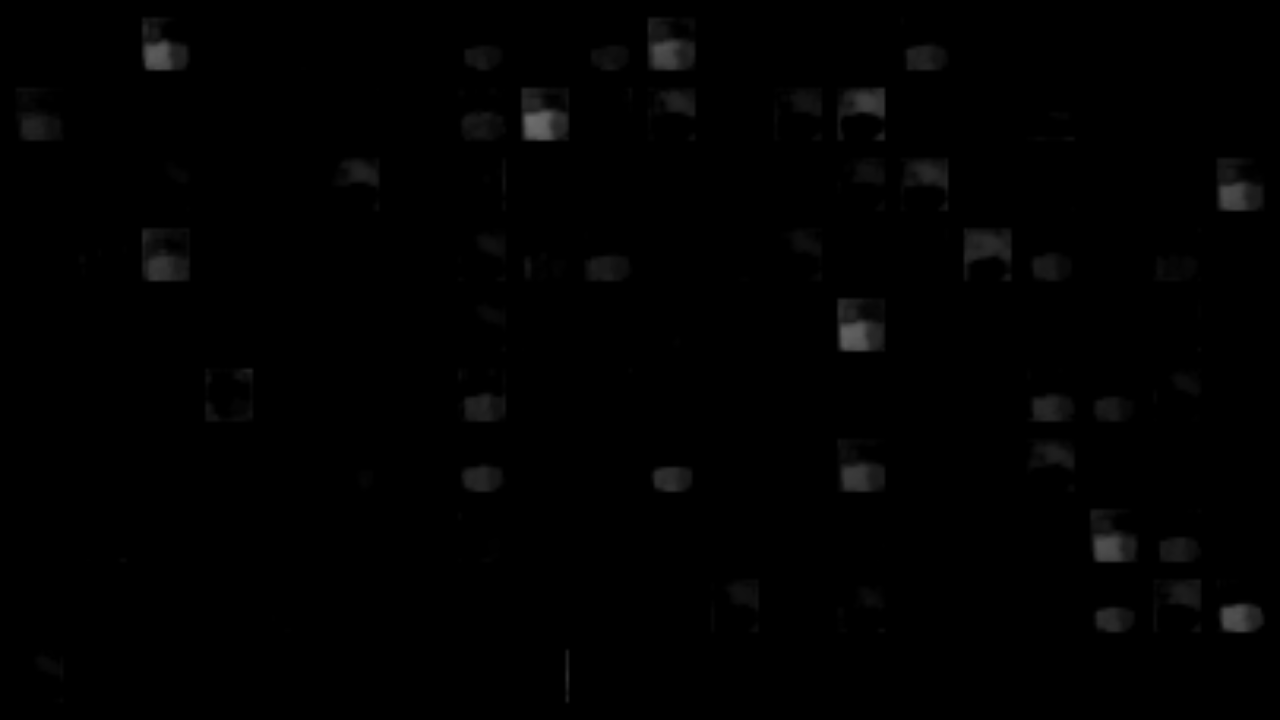

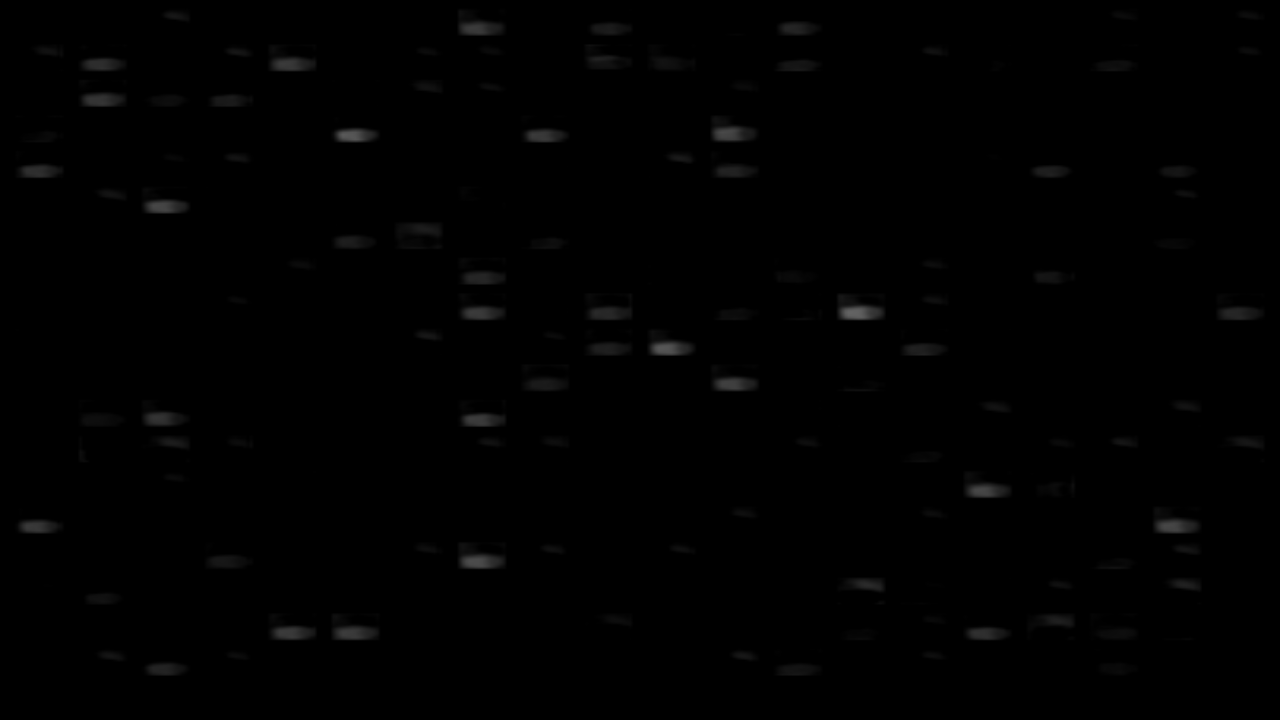

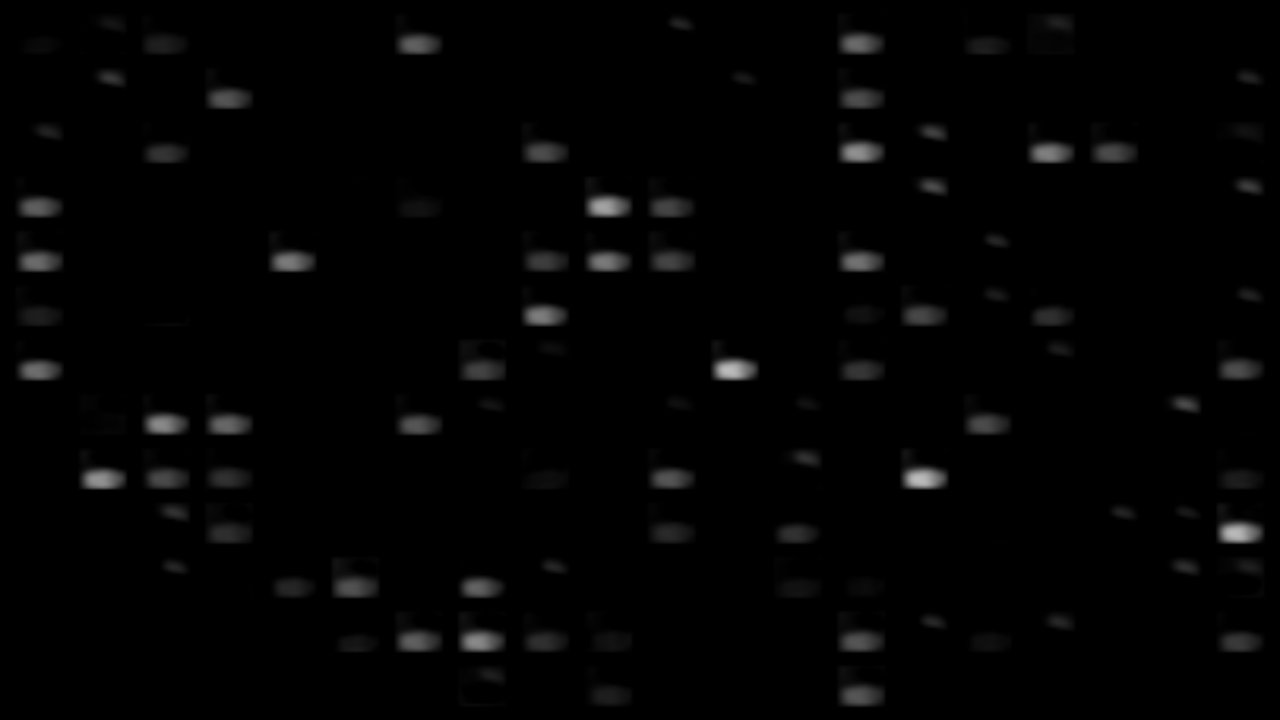

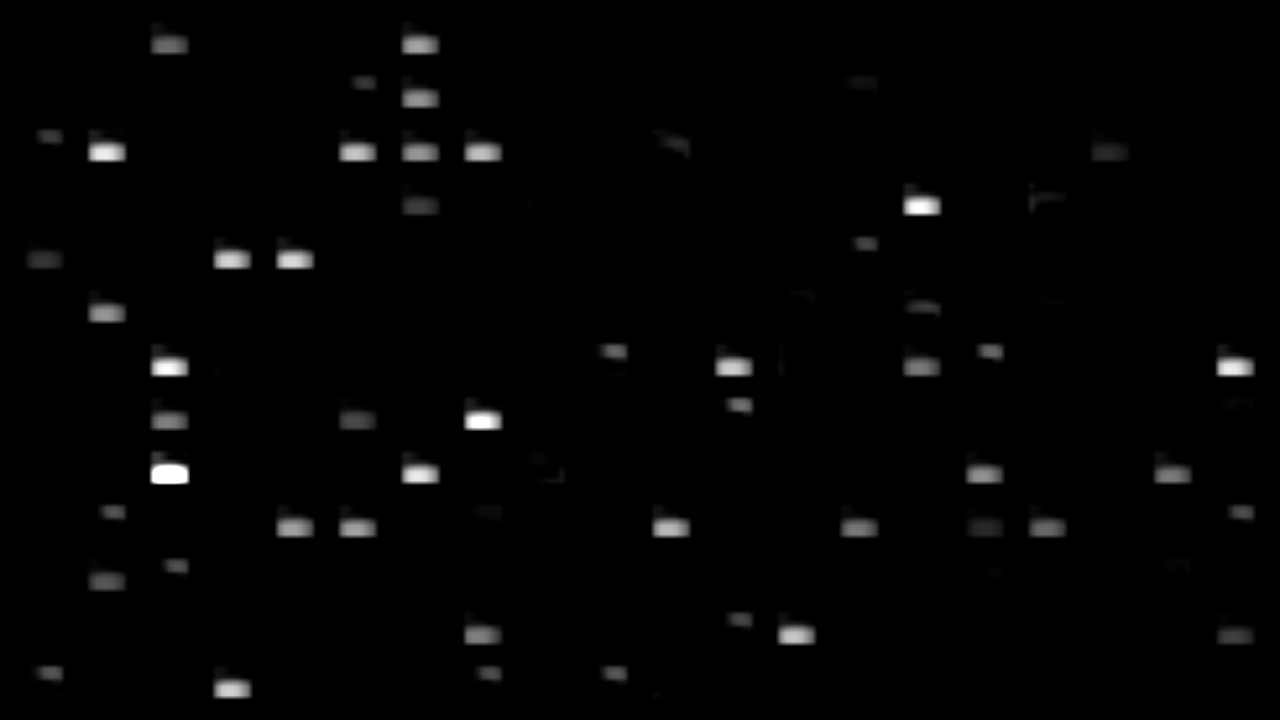

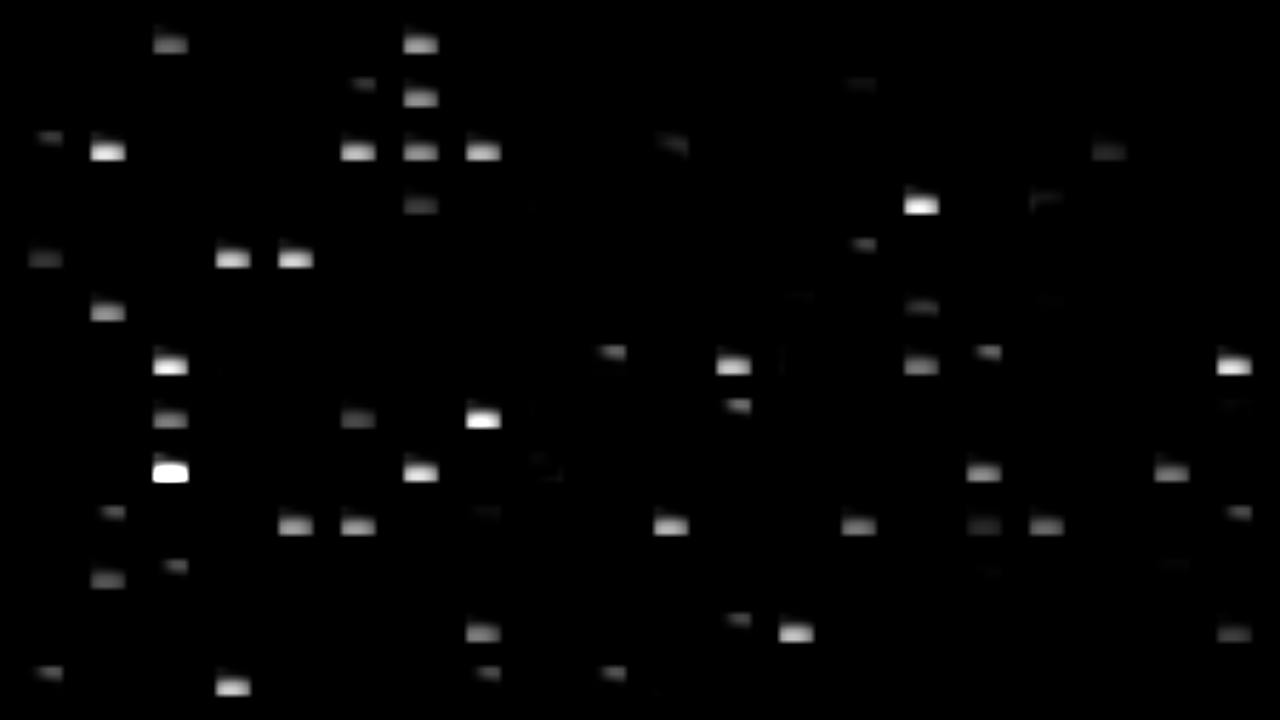

In [ ]:
# Display filters
# Visualize filter of last image processsed (Look inside images folder)
C_model.plot()
for name in sorted(os.listdir("images")):
    path = "images/"+name
    display(Image.open(path))